In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics, feature_selection
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import pytest
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
df=pd.read_csv('2010 Federal STEM Education Inventory Data Set.csv',header=1,low_memory=False)
#Removing last row of total
df=df[:-1]

In [3]:
columns = pd.DataFrame(df.columns.tolist())
columns.loc[columns[0].str.startswith('Unnamed:'), 0] = np.nan
columns[0] = columns[0].fillna(method='ffill')
df.columns=columns
df.columns=pd.MultiIndex.from_tuples(df.columns)
df.columns

Index(['Index Number', 'Investment Name', 'Agency', 'Subagency',
       'A) Brief Description', 'B) Year Established', ' C1) Funding FY2008 ',
       ' C2) Funding FY2009 ', ' C3) Funding FY2010 ',
       'D) Mission-specific or General STEM?',
       ...
       'Y2) Summative Evaluation Type', 'Y2) Summative Evaluation Type',
       'Y3) Process or Implementation Evaluation Type',
       'Y3) Process or Implementation Evaluation Type',
       'Y3) Process or Implementation Evaluation Type',
       'Y4) Portfolio Evaluation/Review Type',
       'Y4) Portfolio Evaluation/Review Type',
       'Y4) Portfolio Evaluation/Review Type', 'Y5) Expert Review Type',
       'Y5) Expert Review Type'],
      dtype='object', length=256)

# Step1

In [4]:
df_req=df[[' C1) Funding FY2008 ',' C2) Funding FY2009 ']]
df_req=df_req.rename(index=str,columns={' C1) Funding FY2008 ':'FY2008',' C2) Funding FY2009 ':'FY2009'})
df_req=df_req.replace(' -   ',np.nan)
#df_req

In [5]:
df_req['FY2008']=df_req['FY2008'].astype(float)
df_req['FY2009']=df_req['FY2009'].astype(float)
df_req=df_req.dropna(axis=0)
df=df.iloc[df_req.index]

In [6]:
df

Index Number                                    Investment Name  \
0       PRG_0001  Centers for Ocean Sciences Education Excellence ~   
1       PRG_0002        Broadening Participation in Computing (BPC)   
2       PRG_0003  CISE Pathways to Revitalized Undergraduate Com...   
3       PRG_0004  Opportunities for Enhancing Diversity in the G...   
4       PRG_0005                               Geoscience Education   
5       PRG_0006            Geoscience Teacher Training (GEO-Teach)   
6       PRG_0007  Global Learning and Observations to Benefit th...   
7       PRG_0008        Graduate Research Fellowship Program (GRFP)   
8       PRG_0009  Integrative Graduate Education and Research Tr...   
9       PRG_0010  Graduate Teaching Fellows in K-12 Education (G...   
10      PRG_0012  East Asia & Pacific Summer Institutes for U.S....   
11      PRG_0013  Undergraduate Research and Mentoring in the Bi...   
12      PRG_0014             Advanced Technological Education (ATE)   
13      PRG_0015    Transforming Undergrad Education in STEM (TUES)   
15      PRG_0017  Excellence Awards in Science and Engineering (...   
16      PRG_0018  Federal Cyber Service: Scholarship for Service...   
17      PRG_0019                 Math and Science Partnership (MSP)   
18      PRG_0020      Research Experiences for Undergraduates (REU)   
19      PRG_0021           Robert Noyce Scholarship (Noyce) Program   
20      PRG_0022  Science, Technology, Engineering, and Mathemat...   
21      PRG_0023                       Polar Research and Education   
22      PRG_0025  International Research Experiences for Student...   
23      PRG_0026  Enhancing the Mathematical Sciences Workforce ...   
24      PRG_0027  Interdisciplinary Training for Undergraduates ...   
25      PRG_0028                   Discovery Research K-12 (DR-K12)   
26      PRG_0029  Research and Evaluation on Education in Scienc...   
27      PRG_0030                   Informal Science Education (ISE)   
28      PRG_0031  Nanotechnology Undergraduate Education in Engi...   
29      PRG_0032  Research Experiences for Teachers (RET) in Eng...   
30      PRG_0033                         Engineering Education (EE)   
..           ...                                                ...   
212     PRG_0280                 National Sea Grant College Program   
216     PRG_0285  Resident Instruction Grants Program for Instit...   
220     PRG_0290   NIST Summer Institute for MIddle School Teachers   
221     PRG_0291                      1890 Facilities Grant Program   
222     PRG_0292         National Estuarine Research Reserve System   
223     PRG_0293                    Coral Reef Conservation Program   
224     PRG_0294                               NWS Outreach Program   
225     PRG_0295  Hispanic_serving Institutions Education Grants...   
226     PRG_0296  Food and Agricultural Sciences National Needs ...   
227     PRG_0297                  Satellite and Information Service   
228     PRG_0298    Summer Undergraduate Research Fellowship (SURF)   
229     PRG_0299  Ernest F. Hollings Undergraduate Scholarship P...   
231     PRG_0301          University Transportation Centers Program   
232     PRG_0302  Dwight David Eisenhower Transportation Fellows...   
233     PRG_0303  Garrett A. Morgan Technology and Transportatio...   
234     PRG_0306  Summer Transportation Institute Program for Di...   
235     PRG_0308           Air Transportation Centers of Excellence   
236     PRG_0310       Minority Serving Institutions Program (MSIP)   
237     PRG_0311               Dr. Nancy Foster Scholarship Program   
238     PRG_0312  NLM Institutional Grants for Research Training...   
240     PRG_0314  Homeland Security STEM Career Development Gran...   
241     PRG_0315               Scientific Leadership Awards Program   
242     PRG_0316                       Summer Research Team Program   
243     PRG_0317       Homeland Security STEM Summer Intern Program   
244     PRG_0318            

In [7]:
df_req['% growth']=((df_req['FY2009']-df_req['FY2008'])/df_req['FY2008'])*100
df_req['label']=np.where(df_req['% growth']>=0,1,0)

In [8]:
df_req

FY2008   FY2009    % growth  label
0      5.240    7.190   37.213740      1
1     14.000   14.000    0.000000      1
2      5.000    5.000    0.000000      1
3      4.570   11.790  157.986871      1
4      1.630    2.740   68.098160      1
5      3.000    3.000    0.000000      1
6      1.100    1.120    1.818182      1
7     96.020  162.430   69.162674      1
8     64.760   77.990   20.429277      1
9     54.600   58.840    7.765568      1
10     1.750    1.520  -13.142857      0
11     5.090    4.680   -8.055010      0
12    51.460   51.850    0.757870      1
13    37.280   40.860    9.603004      1
15     5.570    5.150   -7.540395      0
16    11.370   14.880   30.870712      1
17    47.870   85.990   79.632338      1
18    62.670  100.470   60.315941      1
19    55.050  115.000  108.900999      1
20    29.480   29.090   -1.322931      0
21     2.290    2.420    5.676856      1
22     2.710    4.220   55.719557      1
23    19.460   26.950   38.489209      1
24     2.320    2.710   16.810345      1
25    99.250  108.410    9.229219      1
26    41.660   42.600    2.256361      1
27    64.450   65.720    1.970520      1
28     1.080    2.000   85.185185      1
29     3.970    5.790   45.843829      1
30    11.500   22.900   99.130435      1
..       ...      ...         ...    ...
212    9.725    9.387   -3.475578      0
216    0.709    0.761    7.334274      1
220    0.100    0.200  100.000000      1
221   16.577   17.280    4.240816      1
222    2.820    3.502   24.184397      1
223    0.826    0.826    0.000000      1
224    1.245    2.530  103.212851      1
225    5.800    6.327    9.086207      1
226    2.800    2.900    3.571429      1
227    6.360    2.976  -53.207547      0
228    0.511    0.627   22.700587      1
229    3.970    5.600   41.057935      1
231   74.439   83.453   12.109244      1
232    1.961    1.989    1.427843      1
233    1.114    1.130    1.436266      1
234    0.642    0.648    0.934579      1
235   13.200   14.100    6.818182      1
236    1.000    1.418   41.800000      1
237    0.468    0.620   32.478632      1
238   10.331   14.661   41.912690      1
240    3.500    2.500  -28.571429      0
241    3.800    3.800    0.000000      1
242    0.170    0.272   60.000000      1
243    0.177    0.224   26.553672      1
244    0.366    0.460   25.683060      1
245   28.720   27.860   -2.994429      0
246   92.400   61.220  -33.744589      0
247   10.130   11.400   12.537019      1
249    0.476    0.486    2.100840      1
251  194.000  341.000   75.773196      1

[213 rows x 4 columns]

# Step 2

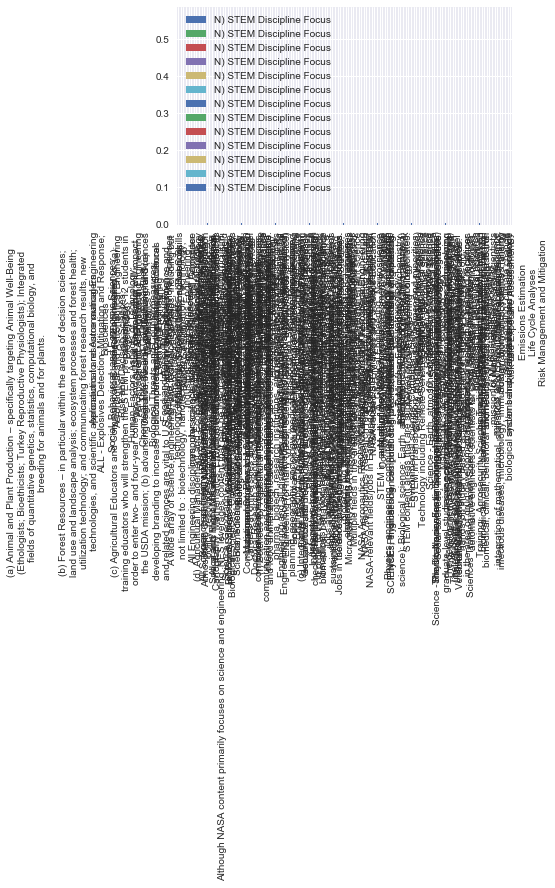

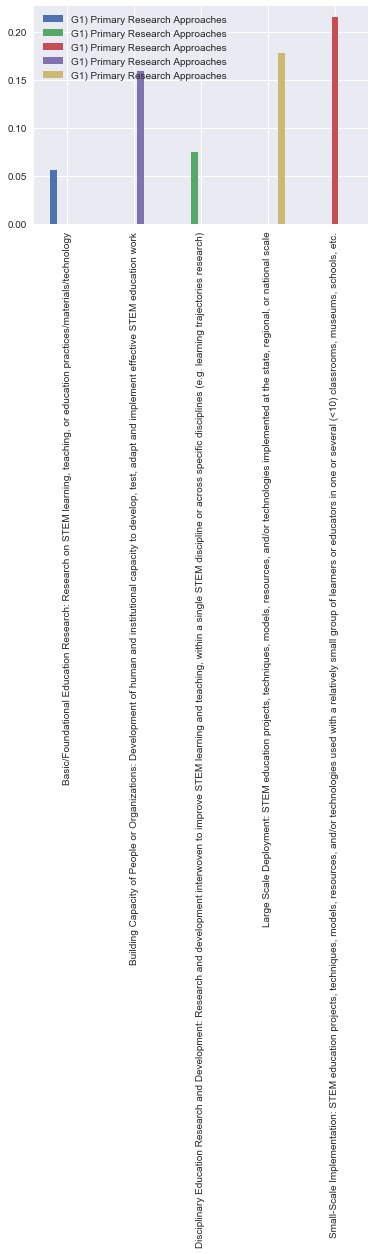

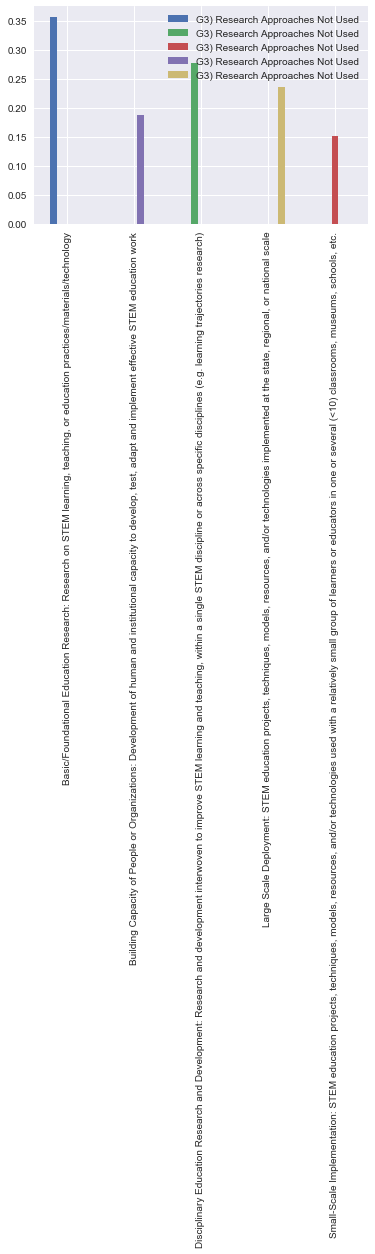

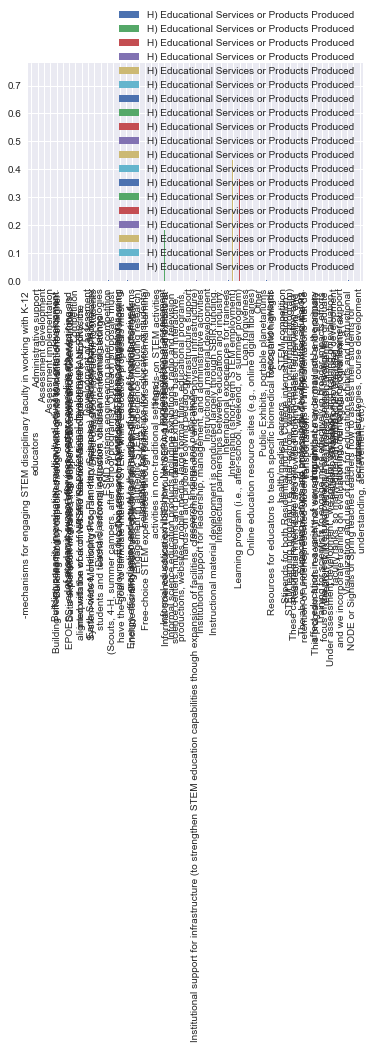

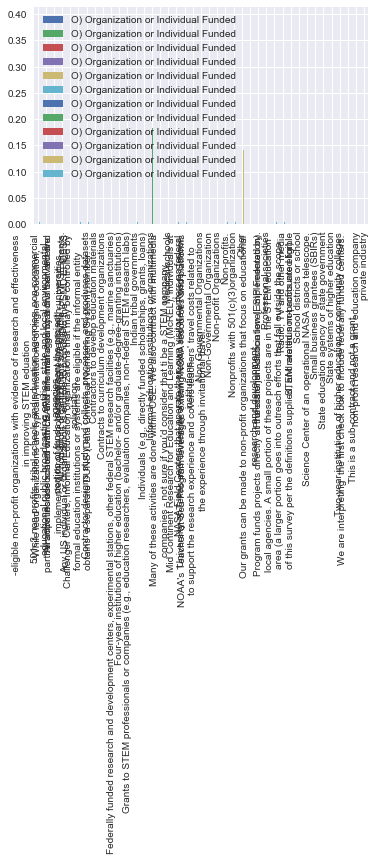

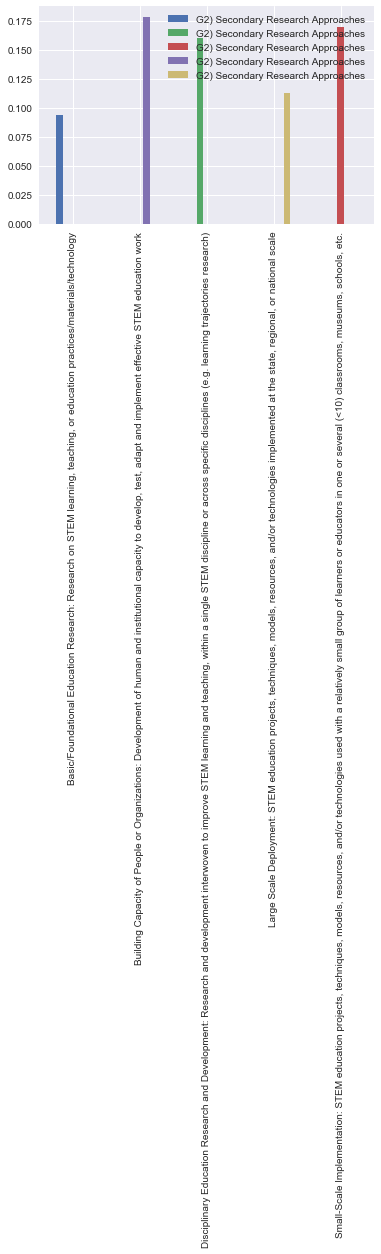

/home/anchit/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:77: RuntimeWarning:

'<' not supported between instances of 'str' and 'float', sort order is undefined for incomparable objects

/home/anchit/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:5539: RuntimeWarning:

'<' not supported between instances of 'float' and 'str', sort order is undefined for incomparable objects

/home/anchit/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:77: RuntimeWarning:

'<' not supported between instances of 'float' and 'str', sort order is undefined for incomparable objects



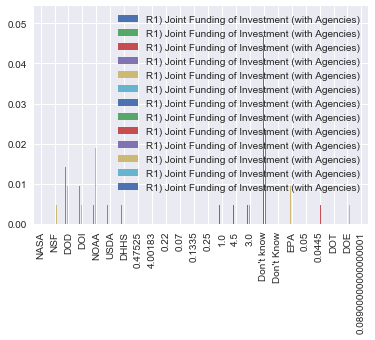

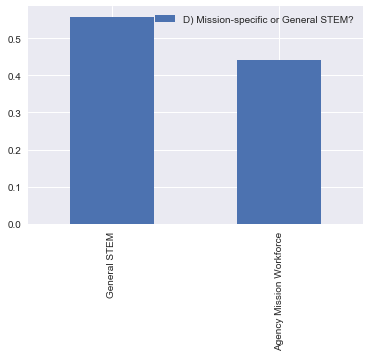

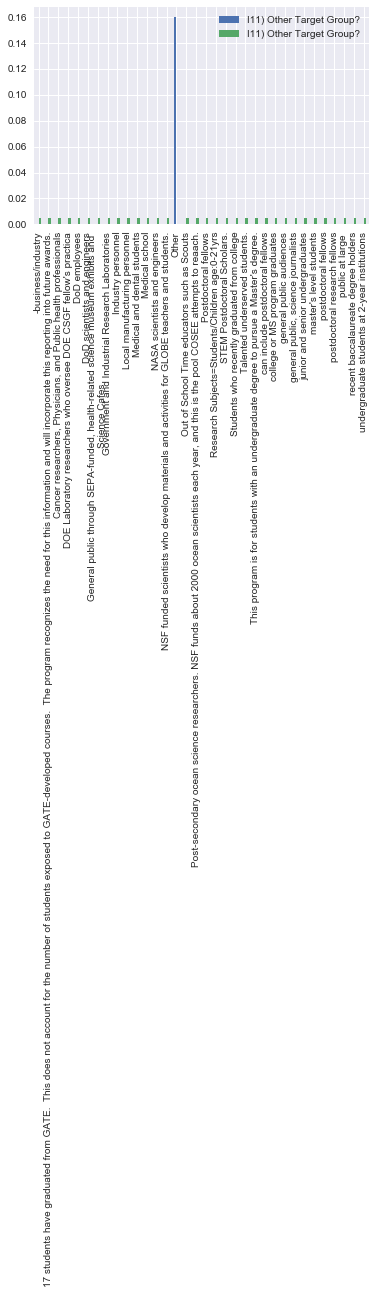

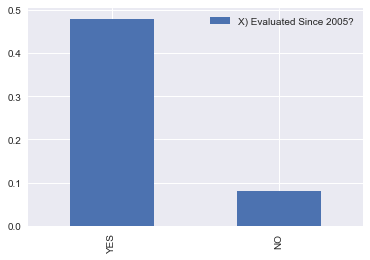

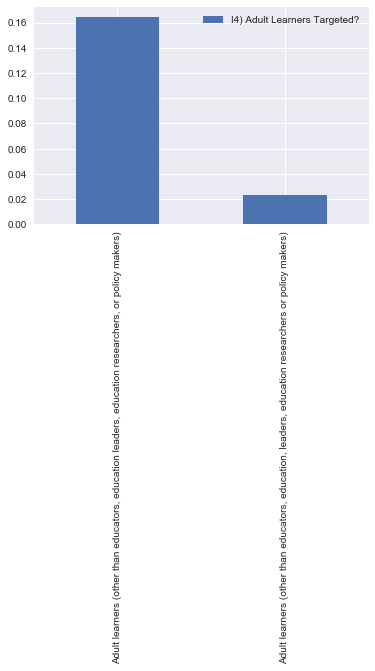

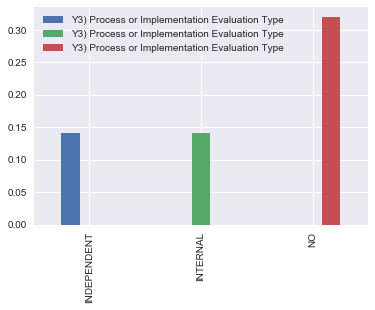

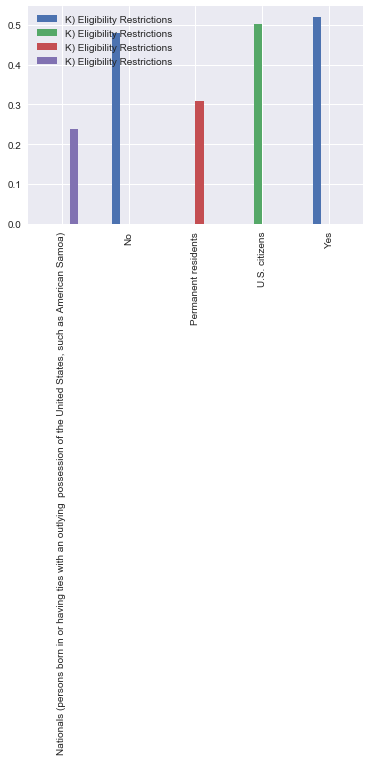

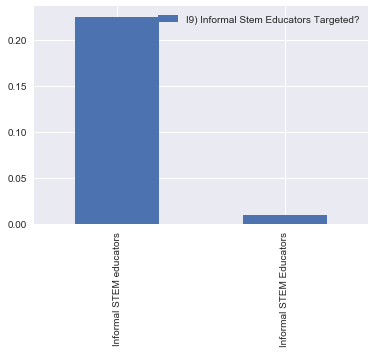

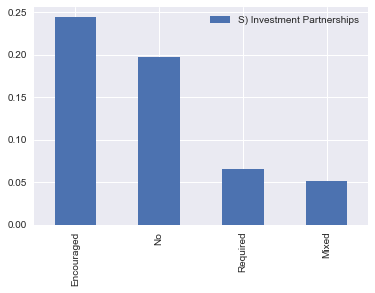

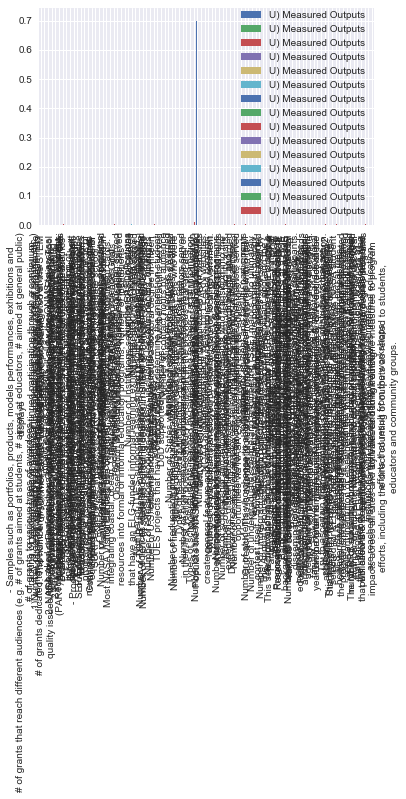

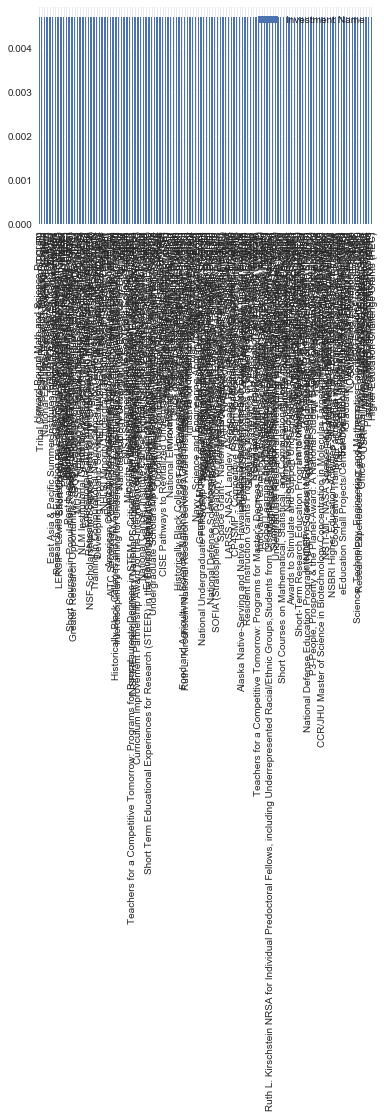

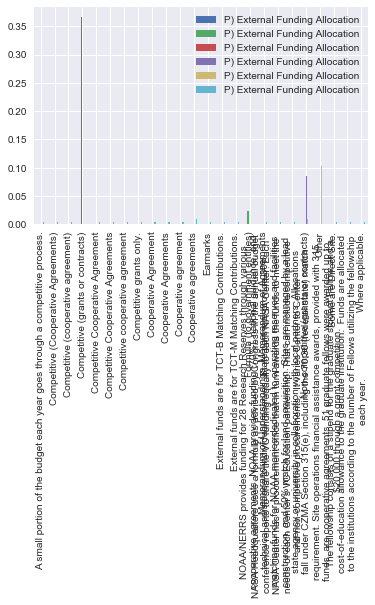

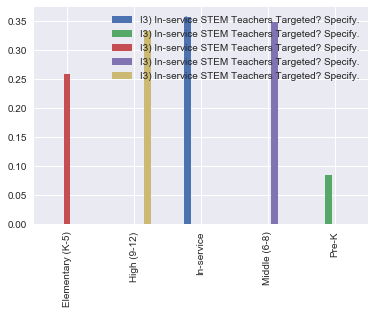

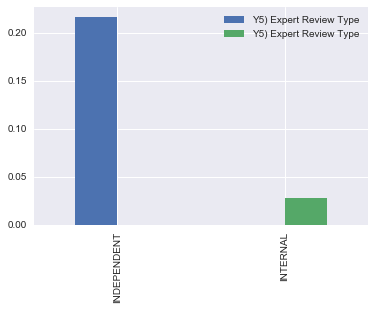

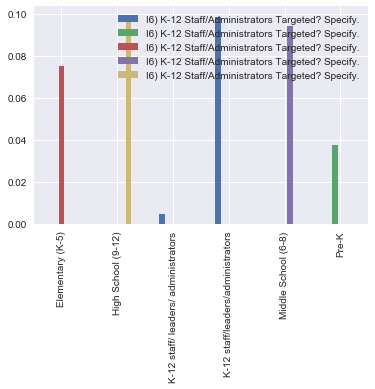

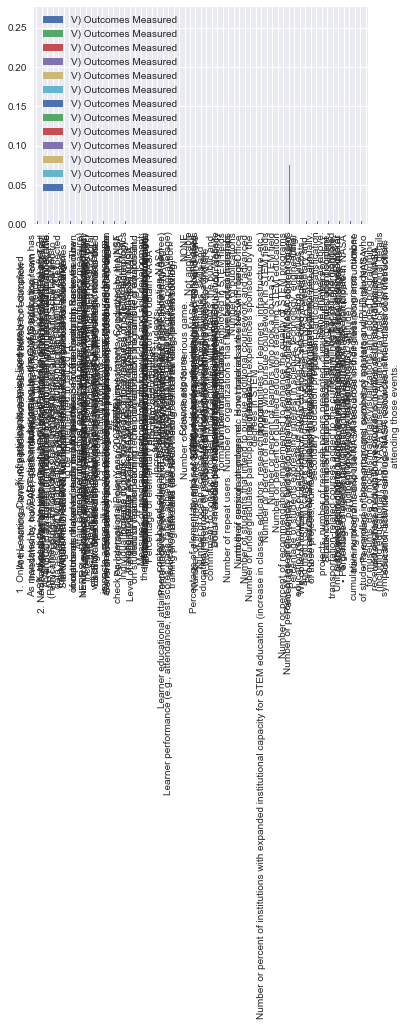

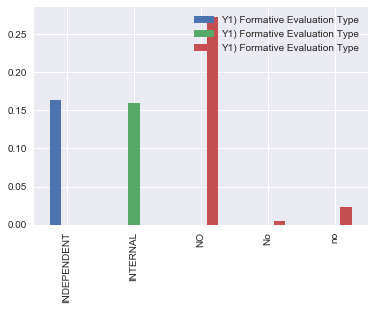

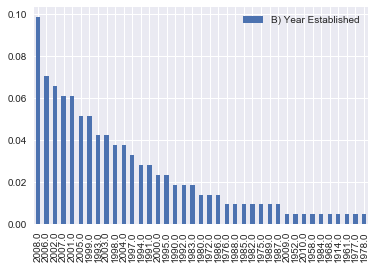

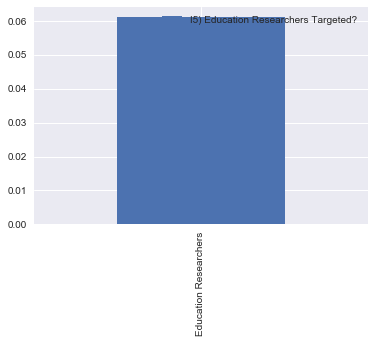

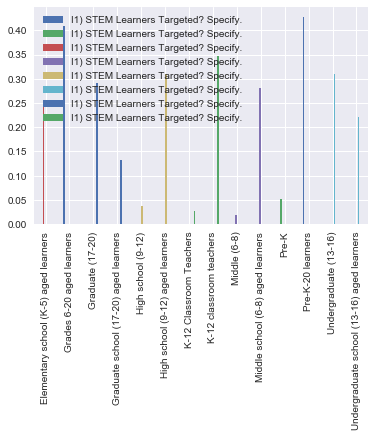

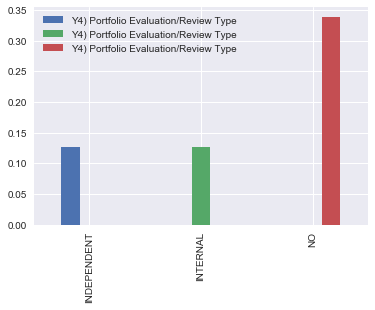

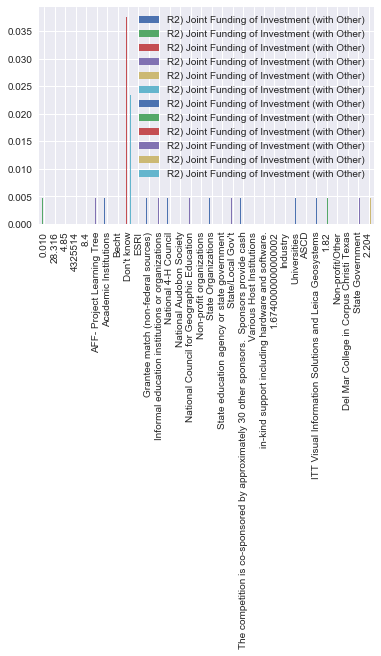

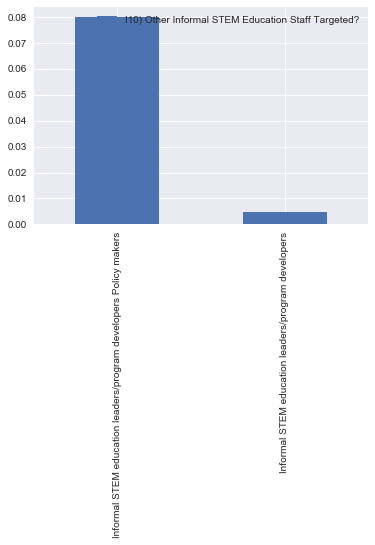

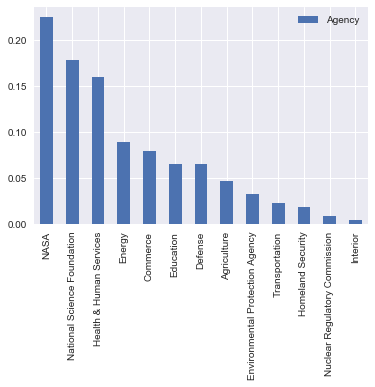

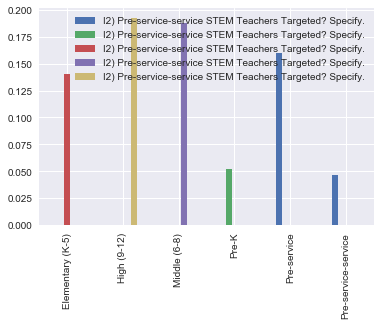

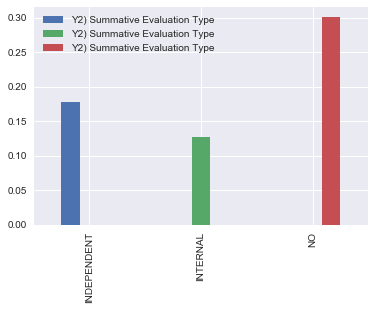

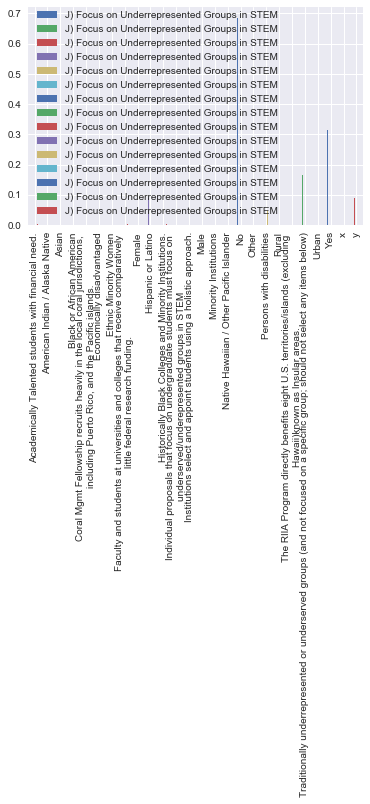

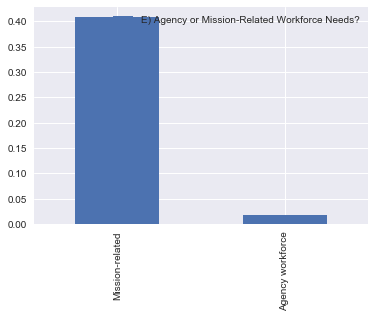

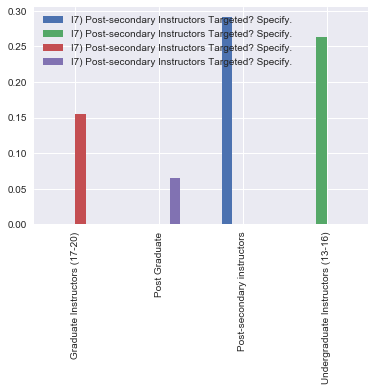

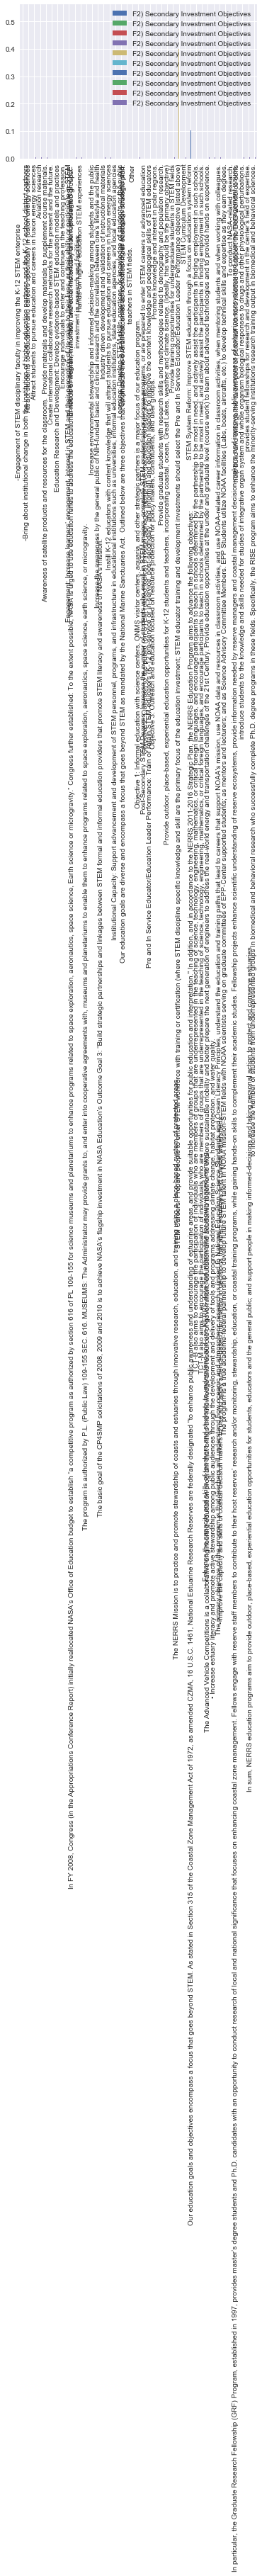

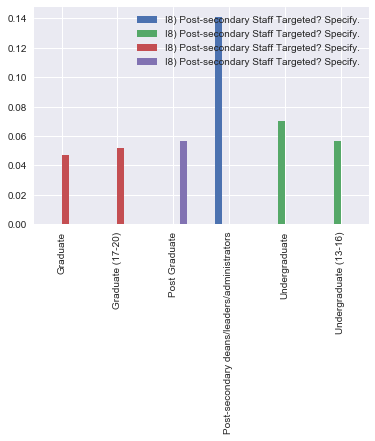

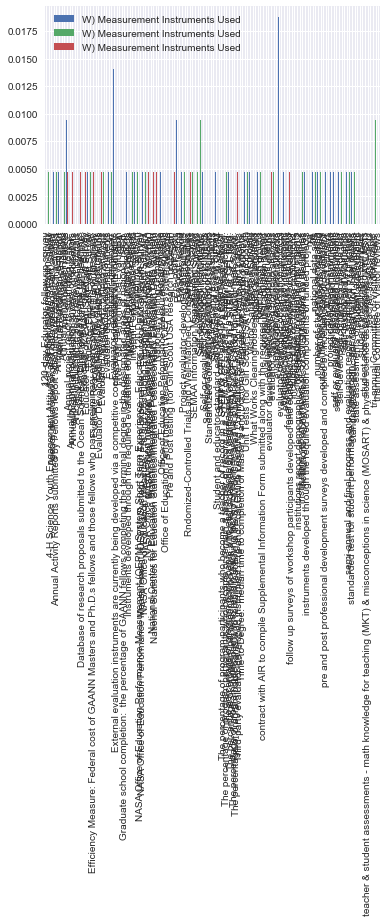

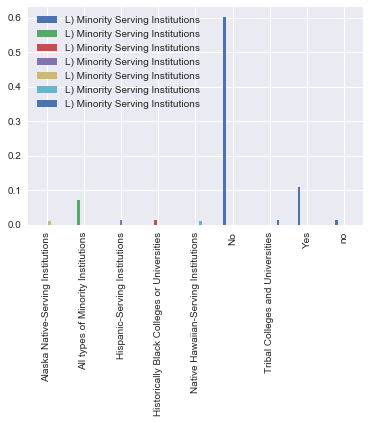

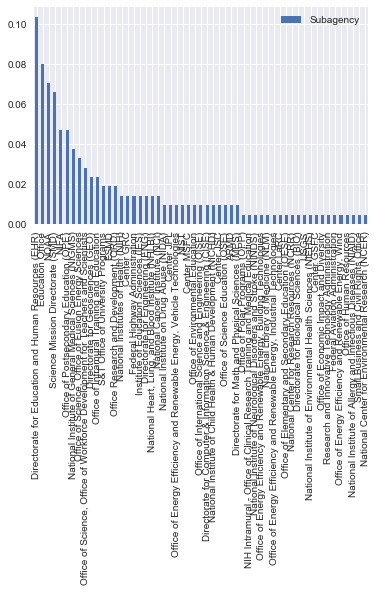

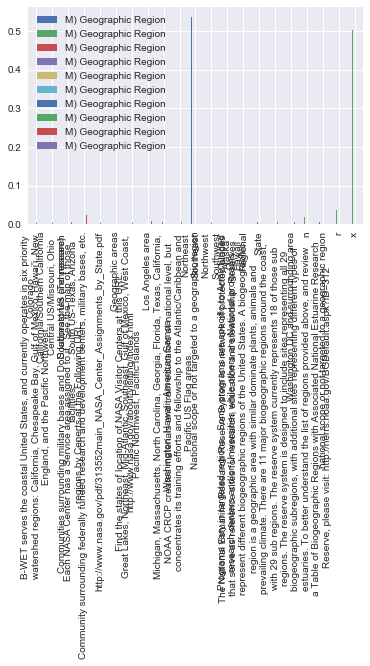

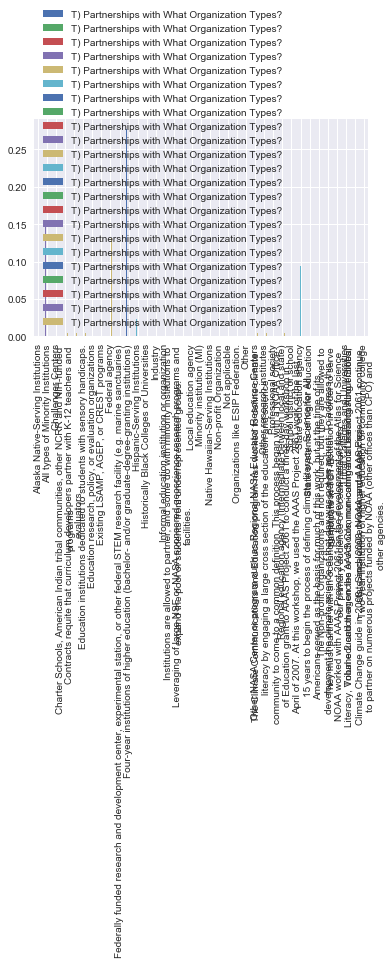

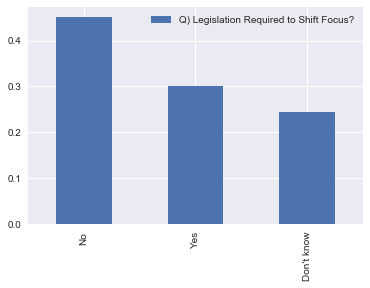

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


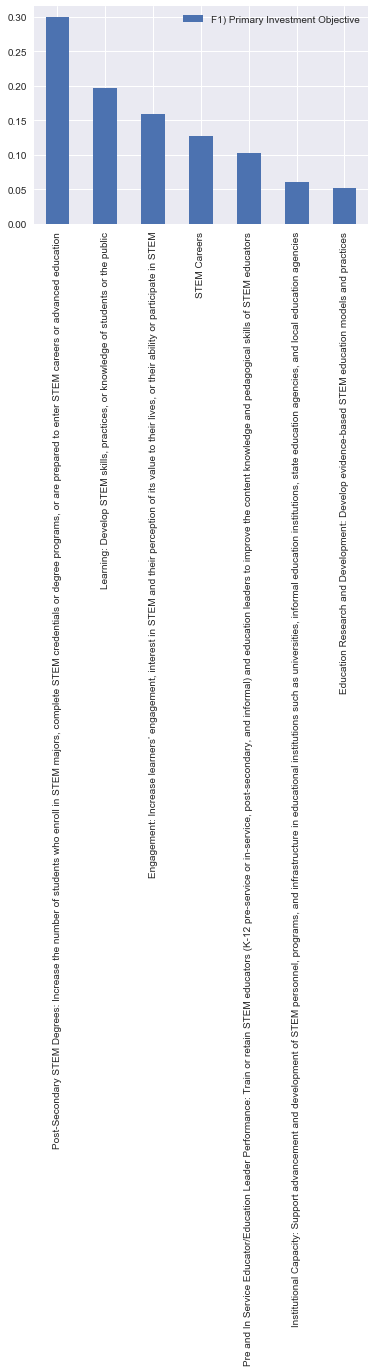

In [9]:
#Part 1
funding_col=[' C1) Funding FY2008 ',' C2) Funding FY2009 ', ' C3) Funding FY2010 ','Index Number']
non_funding_col=list(set(df.columns)-set(funding_col))
for i in non_funding_col:
    #Percentage composition of each attribute value in a column
    dff=pd.DataFrame(df[i]).apply(pd.Series.value_counts)/len(df)
    dff.plot(kind='bar')
    plt.show()
    plt.close()

In [10]:
#Part 2
dff=pd.DataFrame()
tye=type(pd.DataFrame())
for i in non_funding_col:
    if type(df[i])==type(pd.DataFrame()):
        num_cols=len(df[i].columns)
        for j in range(num_cols):
            e=pd.get_dummies(df[i].iloc[:,j])
            if e.empty:
                continue
            e=e.iloc[:,0]
            dff[str(i)+'_'+str(e.name)]=e
            score=metrics.mutual_info_score(e, df_req['label'])
            print(i," ",e.name,' ',score)
            print()
    else:
        e=pd.get_dummies(df[i]).iloc[:,0]
        dff[str(i)+'_'+str(e.name)]=e
        score=metrics.mutual_info_score(e, df_req['label'])
        print(i,' ',score)
        print()

N) STEM Discipline Focus   STEM (no specific subject or field required)   0.002075558275053624

N) STEM Discipline Focus   Science (no specific subject or field required)   0.00039471080371104514

N) STEM Discipline Focus   Science - Physical sciences (including physics, chemistry, astronomy, materials science)   0.0009320844156526231

N) STEM Discipline Focus   Science - Biological science   5.6597278910608395e-05

N) STEM Discipline Focus   Science - Earth, atmospheric, ocean, or planetary science   0.0001551193082934832

N) STEM Discipline Focus   Science - Agricultural science   0.0061691952199086734

N) STEM Discipline Focus   Science - Environmental science   5.6597278910608395e-05

N) STEM Discipline Focus   Science - Computer Science   0.0024679684372541436

N) STEM Discipline Focus   Technology (no specific subject or field required)   0.0033395362293503483

N) STEM Discipline Focus   Engineering (no specific subject or field required)   0.003106349637495176

N) STEM Disciplin


U) Measured Outputs   Number institutions of higher education served   2.615103663231033e-05

U) Measured Outputs   Number of materials distributed or downloaded from websites   0.006561701860949842

U) Measured Outputs   Hours of tutoring, mentoring, or other service provided   0.001119392818620328

U) Measured Outputs   Number of contact hours by audience   0.0009144333173267127

U) Measured Outputs   Hours of tutoring, mentoring, or other service provided   0.001119392818620328

U) Measured Outputs   Number of degrees awarded   0.0007431000043940858

U) Measured Outputs   Other   3.5343180602109836e-05

U) Measured Outputs   # of grants that reach different audiences (e.g. # of grants aimed at students, # aimed at educators, # aimed at general public)
# of grants to various types of awardees
# of grants dedicated to specific environmental issues (e.g. air and water 
quality issues, bidiversity, pesticide use, solid waste, and general 
environmental literacy)   0.001230655558566652


I7) Post-secondary Instructors Targeted? Specify.   Undergraduate Instructors (13-16)   0.0014075009569583241

I7) Post-secondary Instructors Targeted? Specify.   Graduate Instructors (17-20)   0.0009126304747576197

I7) Post-secondary Instructors Targeted? Specify.   Post Graduate   0.001668687316026006

F2) Secondary Investment Objectives   Learning: Develop STEM skills, practices, or knowledge of students or the public   0.0012362864887775216

F2) Secondary Investment Objectives   Engagement: Increase learners’ engagement, interest in STEM and their perception of its value to their lives, or their ability or participate in STEM   0.0032608765206698642

F2) Secondary Investment Objectives   Pre and In Service Educator/Education Leader Performance: Train or retain STEM educators (K-12 pre-service or in-service, post-secondary, and informal) and education leaders to improve the content knowledge and pedagogical skills of STEM educators   0.0036213286518810284

F2) Secondary Investment 

# Step 3

In [11]:
#Part 1
train, test ,label_train, label_test= train_test_split(dff,df_req.iloc[:,3], test_size=0.3)

In [12]:
c=[]
for f in train.columns:
    if(any(x in f for x in set(('[', ']', '<')))):
        f=f.replace('<','')
        print(f)
    c.append(f)
train.columns=c
test.columns=c

G1) Primary Research Approaches_Small-Scale Implementation: STEM education projects, techniques, models, resources, and/or technologies used with a relatively small group of learners or educators in one or several (10) classrooms, museums, schools, etc.
G3) Research Approaches Not Used_Small-Scale Implementation: STEM education projects, techniques, models, resources, and/or technologies used with a relatively small group of learners or educators in one or several (10) classrooms, museums, schools, etc.
G2) Secondary Research Approaches_Small-Scale Implementation: STEM education projects, techniques, models, resources, and/or technologies used with a relatively small group of learners or educators in one or several (10) classrooms, museums, schools, etc.


In [13]:
label_train

75     1
27     1
105    1
34     1
167    1
125    1
77     0
209    0
249    1
193    0
101    1
244    1
57     1
102    1
94     1
99     1
33     1
181    1
174    1
211    1
216    1
224    1
25     1
132    0
240    0
235    1
61     0
158    1
81     0
142    0
      ..
49     1
63     1
6      1
196    1
170    1
1      1
123    1
160    1
188    1
238    1
74     0
135    1
41     1
91     1
12     1
24     1
153    1
66     0
115    0
46     0
163    1
141    0
200    1
228    1
205    1
111    0
187    1
107    0
201    1
16     1
Name: label, Length: 149, dtype: int64

In [14]:
#Part 2
model = XGBClassifier()
model.fit(train, label_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [15]:
label_pred=model.predict(test)
label_pred

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
max_score=0
thrsh=0
thresholds = np.sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = feature_selection.SelectFromModel(model, threshold=thresh,prefit=True)
    select_X_train = selection.transform(train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, label_train)
    # eval model
    select_X_test = selection.transform(test)
    y_pred = selection_model.predict(select_X_test)
    scr=metrics.roc_auc_score(label_test,y_pred)
    if(scr>max_score):
        max_score=scr
        thrsh=thresh
        print(thresh,'           ',select_X_train.shape[1])
        print(metrics.roc_auc_score(label_test,y_pred))
    

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



0.0             240
0.5171526586620926


/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False,

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False,

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False,

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False,

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False,

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False,

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False,

0.006134969             47
0.5265866209262435
0.008179959             43
0.5531732418524871


/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False,

0.016359918             26
0.562607204116638
0.018404908             21
0.572041166380789


/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False,

In [17]:
selection = feature_selection.SelectFromModel(model, threshold=thrsh,prefit=True)
select_X_train = selection.transform(train)
selection_model = XGBClassifier()
selection_model.fit(select_X_train, label_train)
select_X_test = selection.transform(test)
y_pred = selection_model.predict(select_X_test)
print(metrics.roc_auc_score(label_test,y_pred))

0.572041166380789


/home/anchit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [18]:
feature_idx = selection.get_support()
feature_name = dff.columns[feature_idx]
print('Number of features selected: ',select_X_train.shape[1])

Number of features selected:  21


In [19]:
#The selected features
feature_name

Index(['N) STEM Discipline Focus_Engineering (no specific subject or field required)',
       'G3) Research Approaches Not Used_Large Scale Deployment: STEM education projects, techniques, models, resources, and/or technologies implemented at the state, regional, or national scale',
       'H) Educational Services or Products Produced_Direct classroom instruction to students',
       'H) Educational Services or Products Produced_Instructional material development',
       'H) Educational Services or Products Produced_Online education resource sites (e.g., online digital libraries)',
       'H) Educational Services or Products Produced_Recognition awards',
       'H) Educational Services or Products Produced_Tutoring, mentoring, or other learner support',
       'H) Educational Services or Products Produced_Education research to improve STEM teaching and learning',
       'G2) Secondary Research Approaches_Small-Scale Implementation: STEM education projects, techniques, models, resource

In [20]:
#Part 3